# Modelling

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pickle

## Load the data

In [2]:
x = pd.read_pickle("../data/x_final.pickle")
y = pd.read_pickle("../data/y_final.pickle")

## Modeling for one product and store

### First step is to see what a good model looks like for just one single product in one store. Once this process is defined it will be easier to scale it for all the products and stores.

In [3]:
# Let's choose one product at random
x = x.loc[(x["store_id"] == "CA_3") & (x["item_id"] == "FOODS_3_586")]
x

,date,store_id,item_id,sales_mvgmean_8,sales_mvgmean_7,sales_mvgmean_9,sales_mvgmean_6,sales_mvgmean_2,sales_mvgmean_10,sales_mvgmean_3,...,sell_price_lag_3,sell_price_lag_7,sell_price_lag_5,stock_outage_3_lag_1,stock_outage_7_lag_1,stock_outage_15_lag_1,event_name_1_no_event,event_type_1_no_event,event_type_1_te,event_name_1_te
7343,2013-01-16,CA_3,FOODS_3_586,9.12,9.14,9.33,9.33,11.50,9.10,8.33,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7344,2013-01-17,CA_3,FOODS_3_586,8.75,8.86,8.78,8.17,9.00,9.00,9.67,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7345,2013-01-18,CA_3,FOODS_3_586,9.38,8.86,9.22,9.17,9.50,9.20,10.33,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7346,2013-01-19,CA_3,FOODS_3_586,8.75,9.00,9.22,8.67,10.50,9.10,9.00,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
7347,2013-01-20,CA_3,FOODS_3_586,9.50,9.29,9.22,10.50,10.50,9.60,11.33,...,1.48,1.48,1.48,0.00,0.00,0.00,1.00,1.00,28.85,28.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8387,2015-11-26,CA_3,FOODS_3_586,7.38,7.00,7.11,6.83,5.00,7.10,6.00,...,1.58,1.58,1.58,0.00,0.00,0.00,0.00,0.00,28.35,28.87
8388,2015-11-27,CA_3,FOODS_3_586,7.88,7.86,8.11,8.50,9.50,7.80,8.00,...,1.58,1.58,1.58,0.00,0.00,0.00,1.00,1.00,28.85,28.85
8389,2015-11-28,CA_3,FOODS_3_586,8.12,8.71,8.11,8.50,12.00,8.30,9.67,...,1.58,1.58,1.58,0.00,0.00,0.00,1.00,1.00,28.85,28.85
8390,2015-11-29,CA_3,FOODS_3_586,8.38,8.14,7.89,8.00,8.00,7.90,10.00,...,1.58,1.58,1.58,0.00,0.00,0.00,1.00,1.00,28.85,28.85


In [4]:
# Get the sales target variable for these specific indexes
y = y[y.index.isin(x.index)]
y

7343     6
7344    13
7345     8
7346    13
7347    13
        ..
8387    14
8388    10
8389     6
8390     7
8391     3
Name: sales, Length: 1049, dtype: int64

### Prepare for modelling

In [5]:
# Feature to be modelled (exclude date, store_id and item_id)
var_model = x.columns.to_list()[3:]

#### In order to introduce cross-validation in time-series datasets it is necessary to carry out a different format of the cross-validation concept. For this case, we are going to use 3 different validation data splits which are 8 days long each one.

In [6]:
# The test_size should be similar to the time frame we want to predict when
# the model is finished
time_cv = TimeSeriesSplit(n_splits=3, test_size=8) 

### Hyperparameter tuning

In [7]:
# Using the default option of LightGBM works very well in this case

pipe = Pipeline([("algorithm", HistGradientBoostingRegressor())])

grid = [    {"algorithm": [HistGradientBoostingRegressor()]
            #  "algorithm__learning_rate": [0.01, 0.025, 0.05, 0.1],
            #  "algorithm__max_iter": [50, 100, 200],
            #  "algorithm__max_depth": [5, 10, 20],
            #  "algorithm__min_samples_leaf": [500],
            #  "algorithm__scoring": ["neg_mean_absolute_error"],
            #  "algorithm__l2_regularization": [0, 0.25, 0.5, 0.75, 1],
             }
            # More algorithms could be added here if we wanted to test more

]

#### Apply random search

In [8]:
random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 25, 
                                   cv = time_cv, 
                                   scoring = "neg_mean_absolute_error", 
                                   verbose = 0,
                                   n_jobs = -1)

model = random_search.fit(x[var_model], y)

pd.DataFrame(random_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.42,0.00,0.00,0.00,HistGradientBoostingRegressor(),{'algorithm': HistGradientBoostingRegressor()},-4.24,-2.01,-3.44,-3.23,0.92,1


In [9]:
# Get the best model from the random search
final_model = model.best_estimator_.fit(x[var_model],y)

In [10]:
# Predict the sales with the final model for the given product
prediction = final_model.predict(x[var_model])
prediction

array([ 7.37421835, 10.71937997,  9.72968981, ...,  7.33490276,
        7.84192341,  5.81088683])

In [11]:
# Create dataframe concatenating the actual value and the predictions
temp = pd.concat([x["date"].reset_index(drop=True), y.reset_index(drop=True), pd.Series(prediction, name="prediction")], axis=1).set_index("date")
temp

,sales,prediction
date,,
2013-01-16,6,7.37
2013-01-17,13,10.72
2013-01-18,8,9.73
2013-01-19,13,11.34
2013-01-20,13,11.28
...,...,...
2015-11-26,14,11.10
2015-11-27,10,10.12
2015-11-28,6,7.33


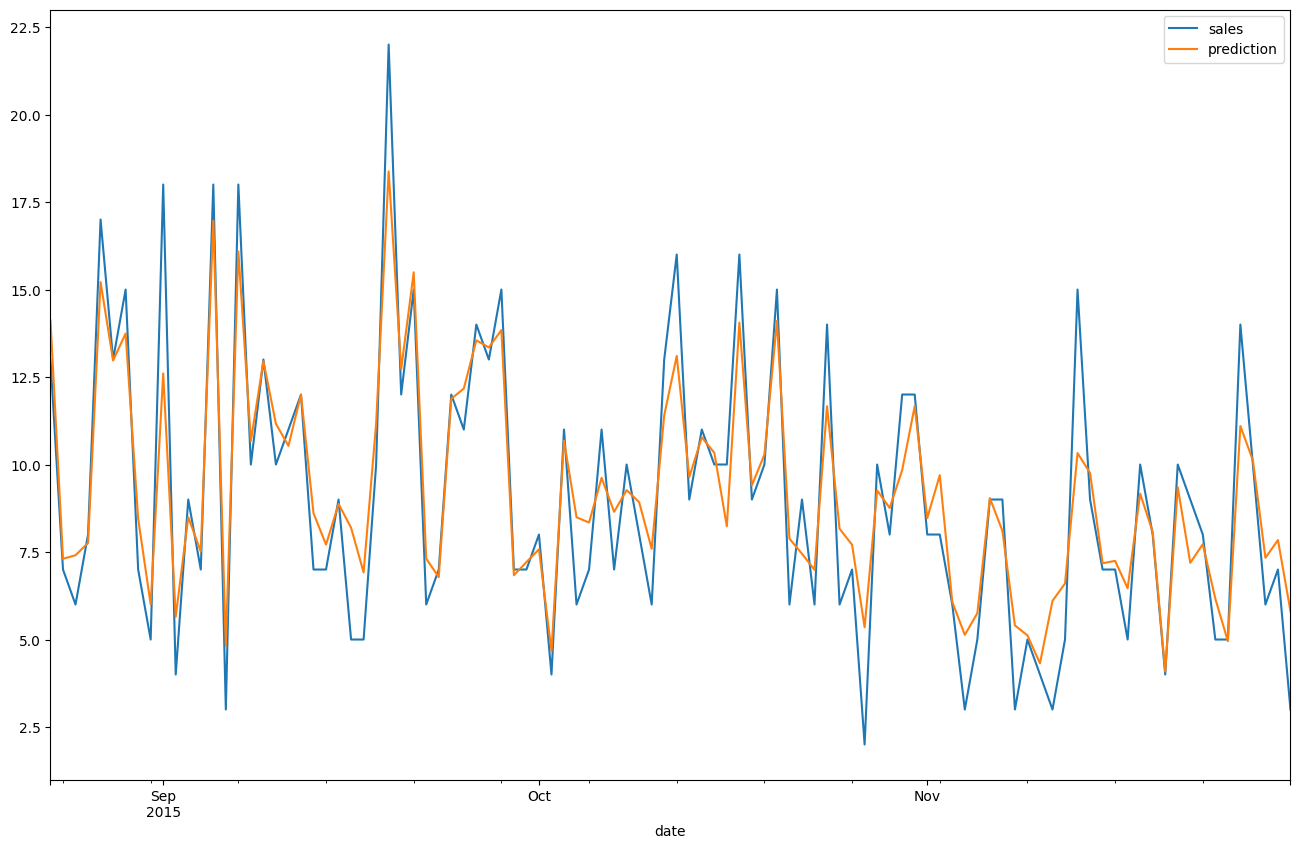

In [12]:
# Plot the predictions
temp.tail(100).plot(figsize = (16,10));

## Modelling all the products

### The modelling process works for one product, so let's implement it for the whole product inventory for every store.

In [13]:
# Let's reload the data again
x = pd.read_pickle("../data/x_final.pickle")
y = pd.read_pickle("../data/y_final.pickle")

### Include a new variable with a store-item combination (and get rid of the original ones)

In [14]:
x.insert(loc=0, column="product_store", value=(x["store_id"] + "_" + x["item_id"]))
x.drop(columns=["item_id","store_id"], inplace=True)

In [15]:
x.head()

,product_store,date,sales_mvgmean_8,sales_mvgmean_7,sales_mvgmean_9,sales_mvgmean_6,sales_mvgmean_2,sales_mvgmean_10,sales_mvgmean_3,sales_mvgmean_5,...,sell_price_lag_3,sell_price_lag_7,sell_price_lag_5,stock_outage_3_lag_1,stock_outage_7_lag_1,stock_outage_15_lag_1,event_name_1_no_event,event_type_1_no_event,event_type_1_te,event_name_1_te
0,CA_3_FOODS_3_090,2013-01-16,233.38,236.00,228.33,242.50,182.00,232.50,215.00,242.00,...,1.25,1.25,1.25,0.00,0.00,0.00,1.00,1.00,28.85,28.85
1,CA_3_FOODS_3_090,2013-01-17,230.38,235.14,228.67,233.50,174.50,224.60,185.00,237.40,...,1.25,1.25,1.25,0.00,0.00,0.00,1.00,1.00,28.85,28.85
2,CA_3_FOODS_3_090,2013-01-18,227.00,224.43,223.67,226.17,180.50,222.80,173.00,201.20,...,1.25,1.25,1.25,0.00,0.00,0.00,1.00,1.00,28.85,28.85
3,CA_3_FOODS_3_090,2013-01-19,224.38,225.86,226.67,205.00,197.00,223.70,195.00,189.80,...,1.25,1.25,1.25,0.00,0.00,0.00,1.00,1.00,28.85,28.85
4,CA_3_FOODS_3_090,2013-01-20,242.88,227.43,239.67,218.50,293.00,240.20,252.00,221.00,...,1.25,1.25,1.25,0.00,0.00,0.00,1.00,1.00,28.85,28.85


### Let's create a list with all the data grouped by product-store combination, in a tuple format. That is, a list of tuples each containing a product-store combination and all the data related to it.

In [16]:
product_store_list = list(x.groupby("product_store"))
product_store_list

[('CA_3_FOODS_3_090',
           product_store       date  sales_mvgmean_8  sales_mvgmean_7  \
  0     CA_3_FOODS_3_090 2013-01-16           233.38           236.00   
  1     CA_3_FOODS_3_090 2013-01-17           230.38           235.14   
  2     CA_3_FOODS_3_090 2013-01-18           227.00           224.43   
  3     CA_3_FOODS_3_090 2013-01-19           224.38           225.86   
  4     CA_3_FOODS_3_090 2013-01-20           242.88           227.43   
  ...                ...        ...              ...              ...   
  1044  CA_3_FOODS_3_090 2015-11-26           134.50           139.43   
  1045  CA_3_FOODS_3_090 2015-11-27           154.00           166.43   
  1046  CA_3_FOODS_3_090 2015-11-28           154.12           157.71   
  1047  CA_3_FOODS_3_090 2015-11-29           149.12           150.43   
  1048  CA_3_FOODS_3_090 2015-11-30           139.38           143.29   
  
        sales_mvgmean_9  sales_mvgmean_6  sales_mvgmean_2  sales_mvgmean_10  \
  0              228

### All the individual modelling process is going to be encapsulated in a single function, which is gonna be used for every product.

In [17]:
def modelling(x_product, y):

    # Feature to be modelled (exclude product_store and date)
    var_model = x_product.columns.to_list()[2:]

    # Cross-validation
    time_cv = TimeSeriesSplit(n_splits=3, test_size=8) 

    # Hyperparameter tuning
    pipe = Pipeline([("algorithm", HistGradientBoostingRegressor())])

    grid = [    {"algorithm": [HistGradientBoostingRegressor()]
                #  "algorithm__learning_rate": [0.01, 0.025, 0.05, 0.1],
                #  "algorithm__max_iter": [50, 100, 200],
                #  "algorithm__max_depth": [5, 10, 20],
                #  "algorithm__min_samples_leaf": [500],
                #  "algorithm__scoring": ["neg_mean_absolute_error"],
                #  "algorithm__l2_regularization": [0, 0.25, 0.5, 0.75, 1],
                }
                # More algorithms could be added here if we wanted to test more

    ]
    # Create models
    random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 1, 
                                   cv = time_cv, 
                                   scoring = "neg_mean_absolute_error", 
                                   verbose = 0,
                                   n_jobs = -1)

    model = random_search.fit(x_product[var_model], y)

    # Get the best model from the random search
    final_model = model.best_estimator_.fit(x_product[var_model],y)

    # Returns the final model for the given product
    return final_model

In [18]:
# Create an empty list to store all the products and trained models for each product
list_models = []

### Loop over the product_store_list on each product to take the product name and apply the modelling function to each product.

In [19]:
for i in product_store_list:
    # Take the name of the product and the data of that product for each element of the list
    product = i[0]
    data = i[1]
    # Get the sales target for the given product
    y_i = y[y.index.isin(data.index)]
    # Use the modelling function to carry out the modelling for each product data
    model = modelling(data, y_i)
    # Append the final model of each product in the empty list defined before
    list_models.append([product, model])

In [20]:
# Show how the list_models looks like
list_models[:5]

[['CA_3_FOODS_3_090',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])],
 ['CA_3_FOODS_3_120',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])],
 ['CA_3_FOODS_3_202',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])],
 ['CA_3_FOODS_3_252',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])],
 ['CA_3_FOODS_3_288',
  Pipeline(steps=[('algorithm', HistGradientBoostingRegressor())])]]

### This whole process is to make sure the modelling methodology is applied correctly. So the goal is not to look for the best forecasting model for each product yet.

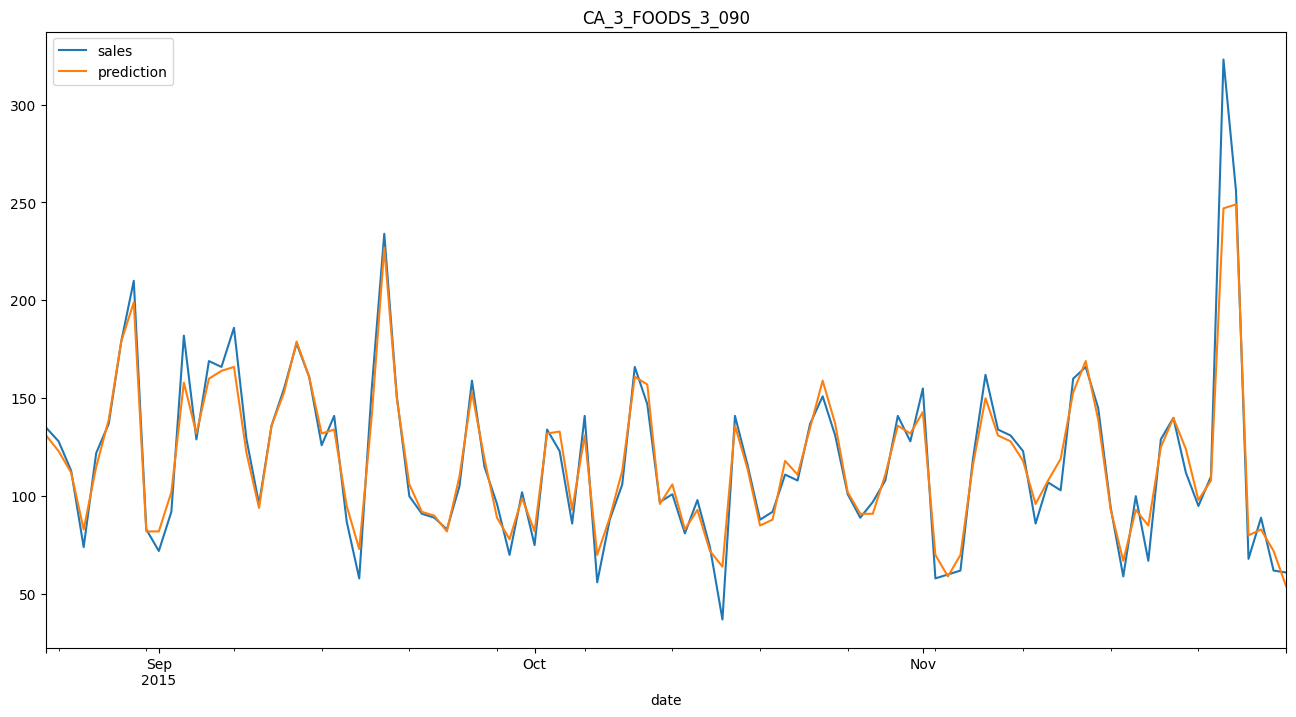

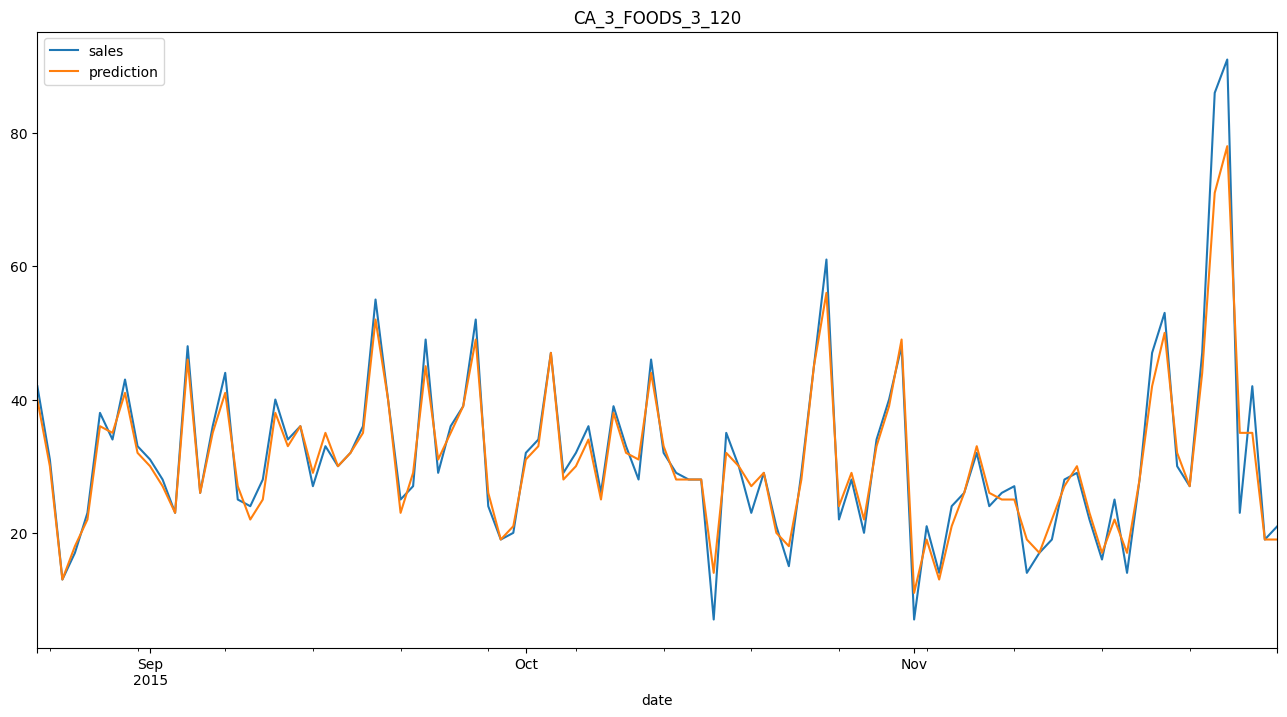

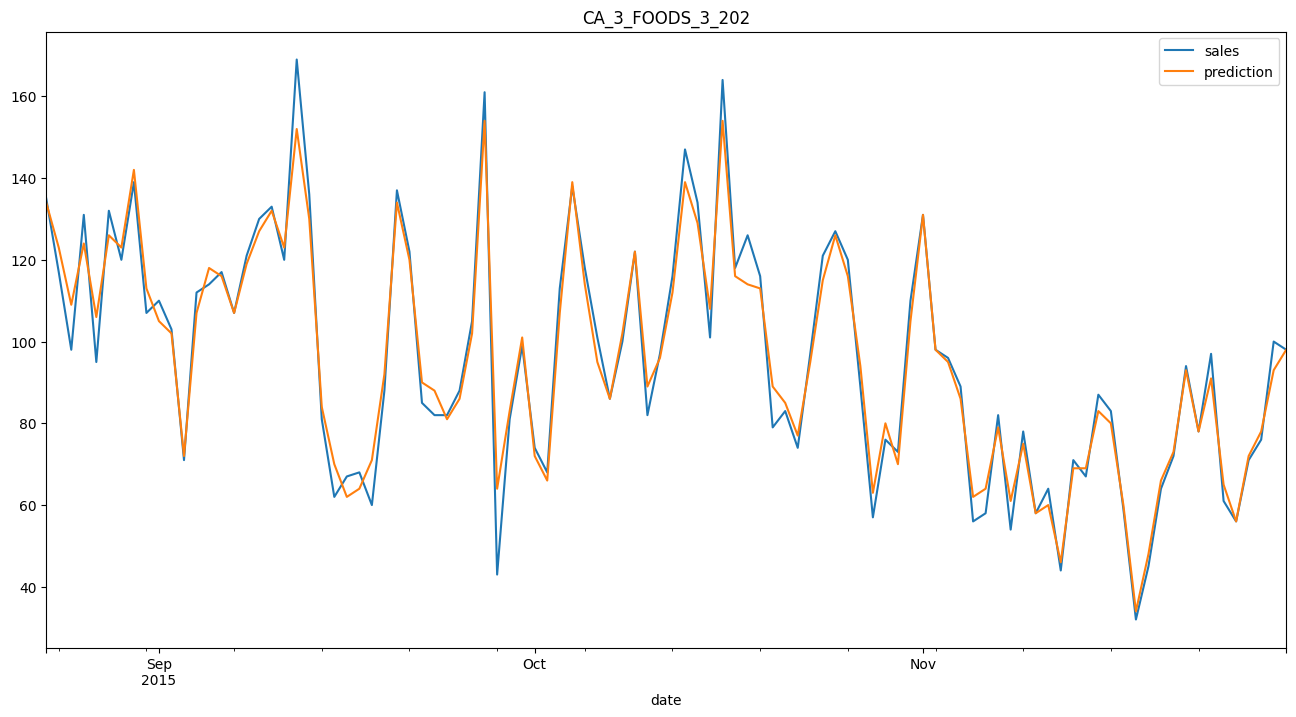

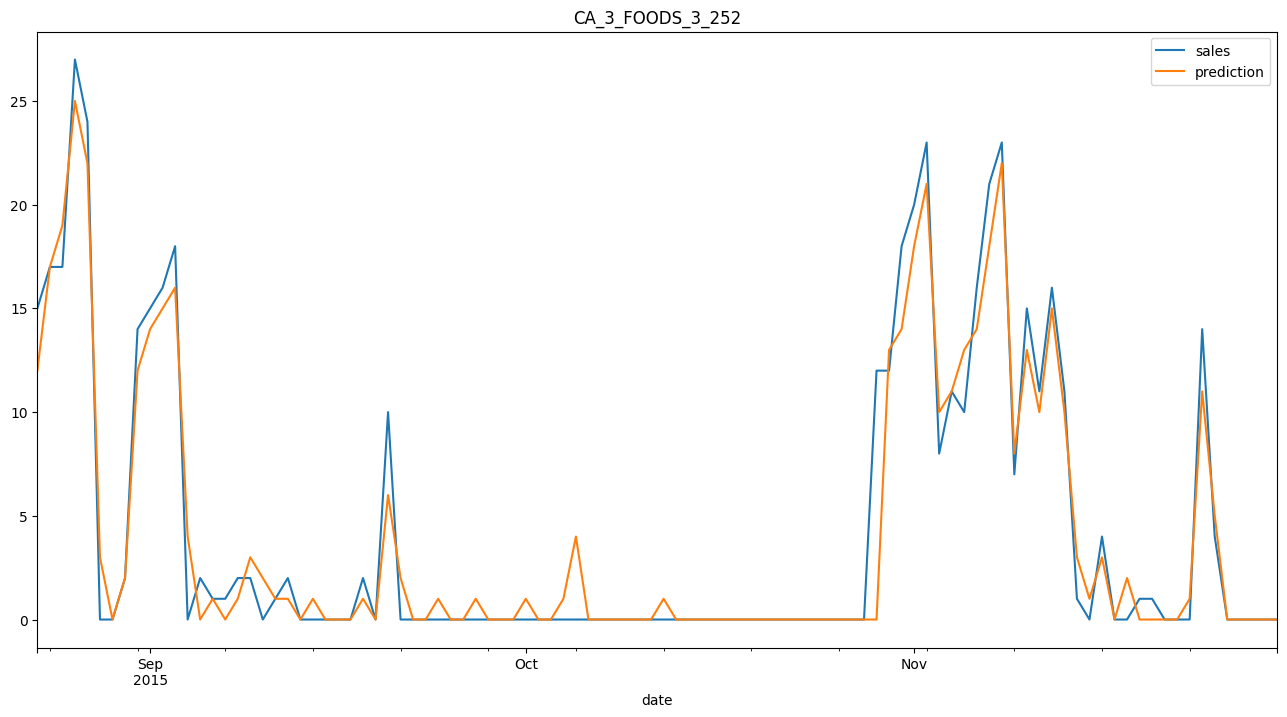

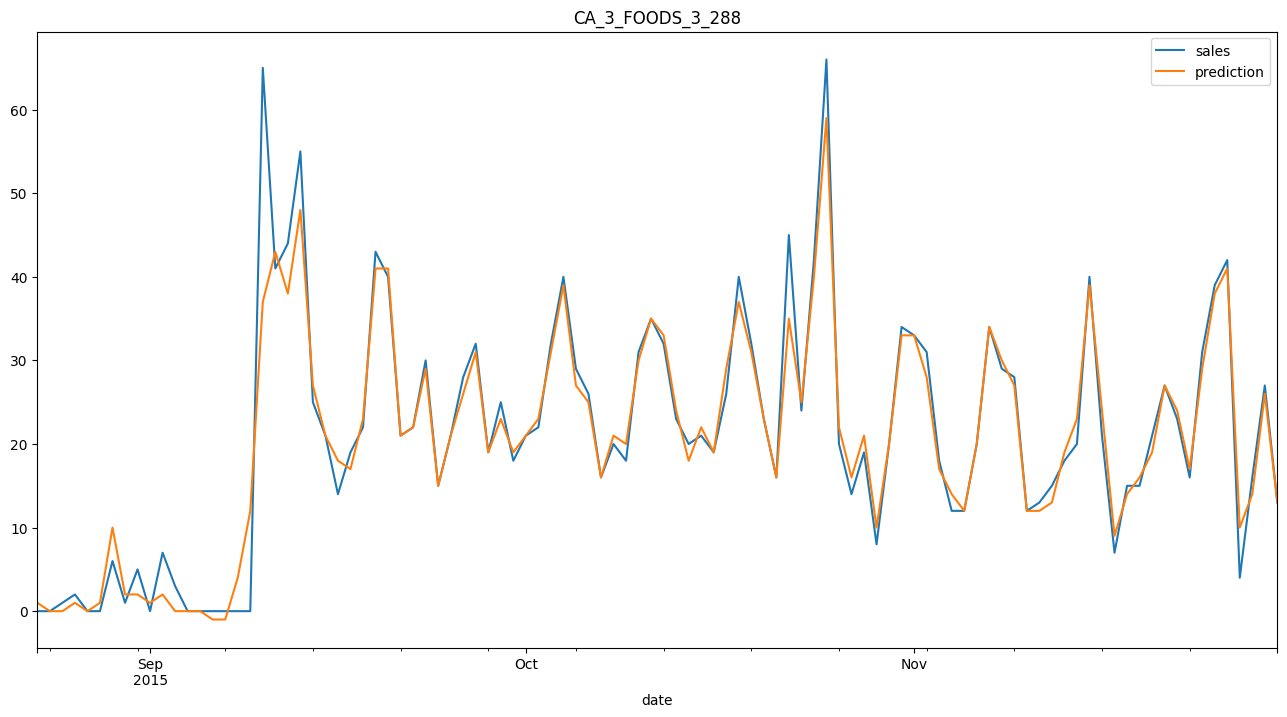

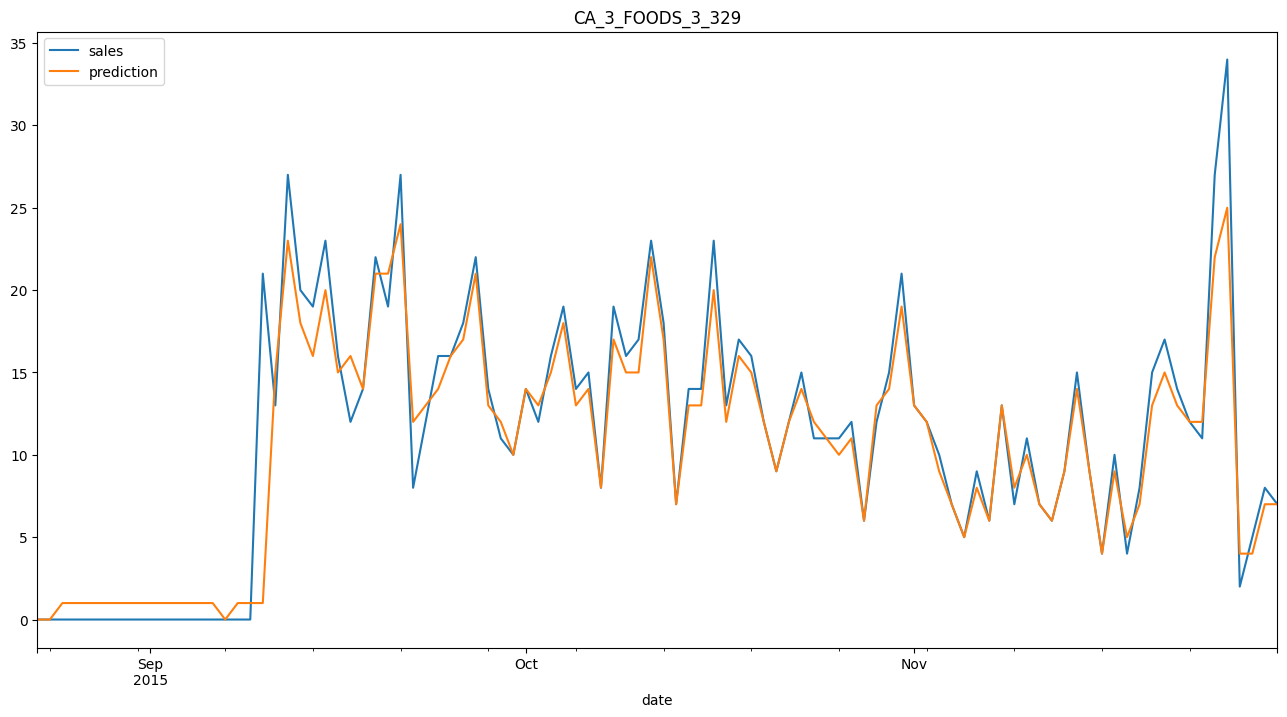

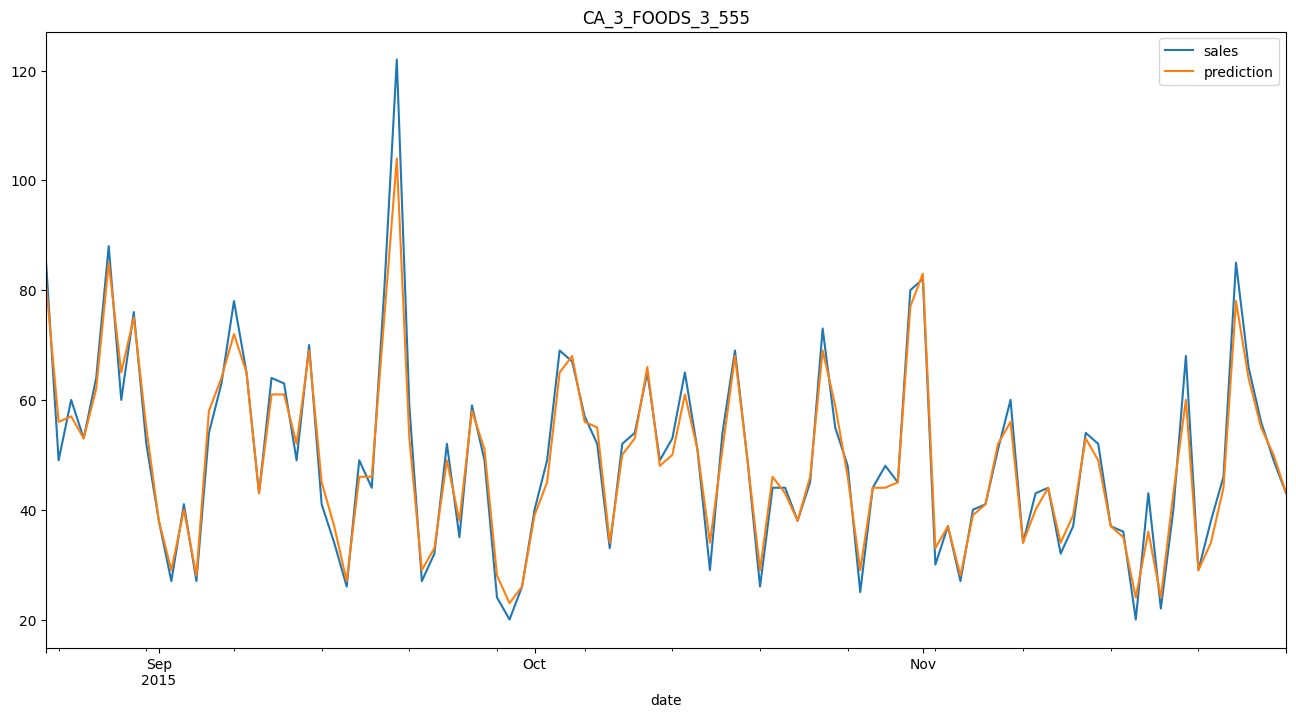

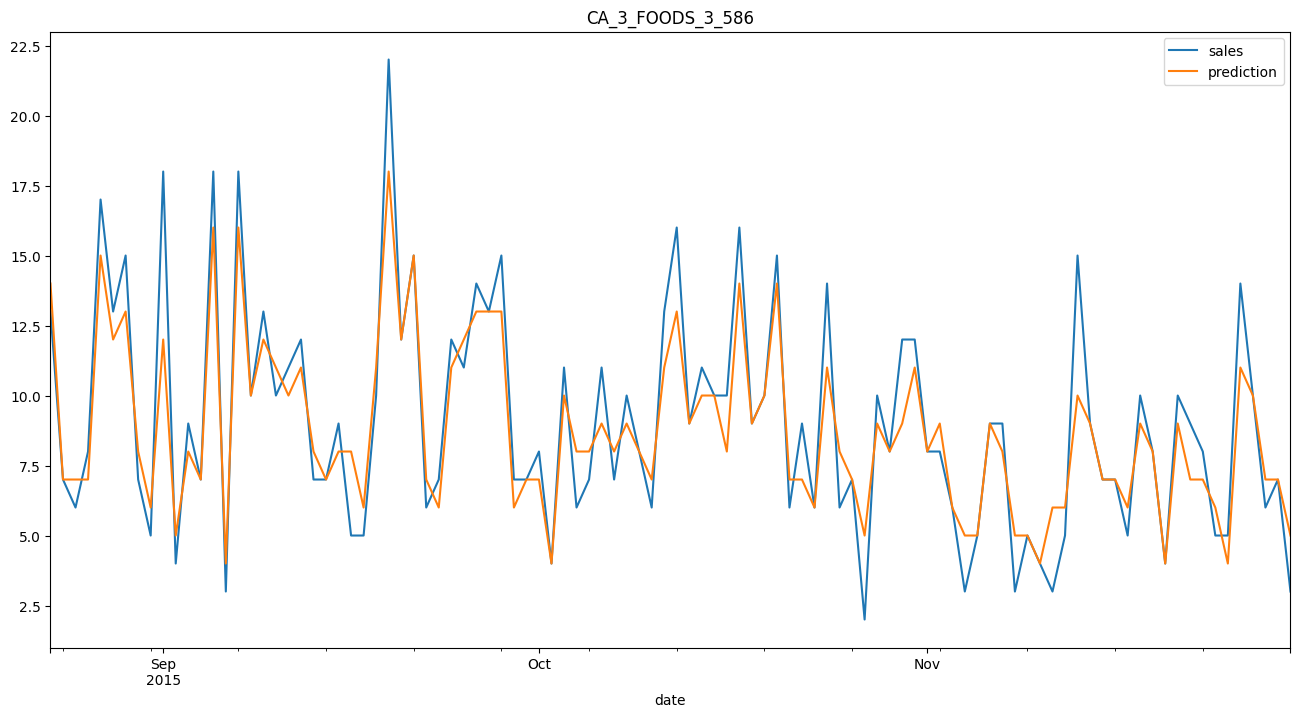

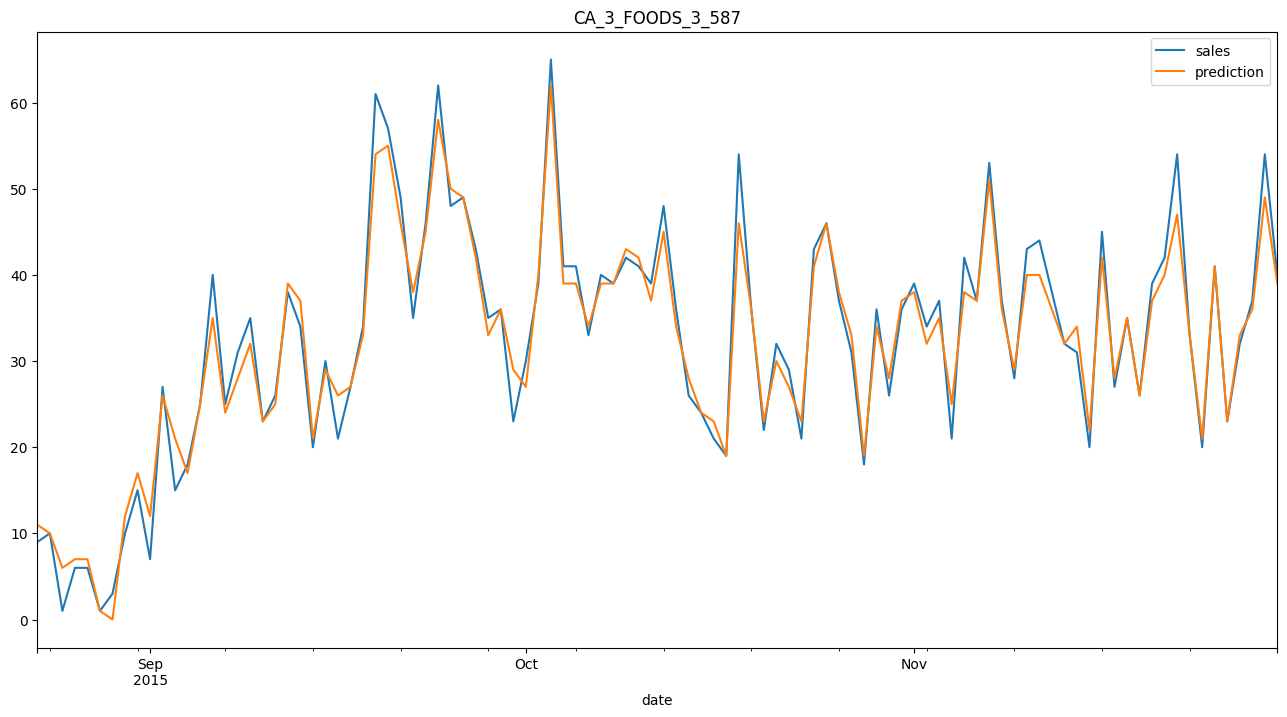

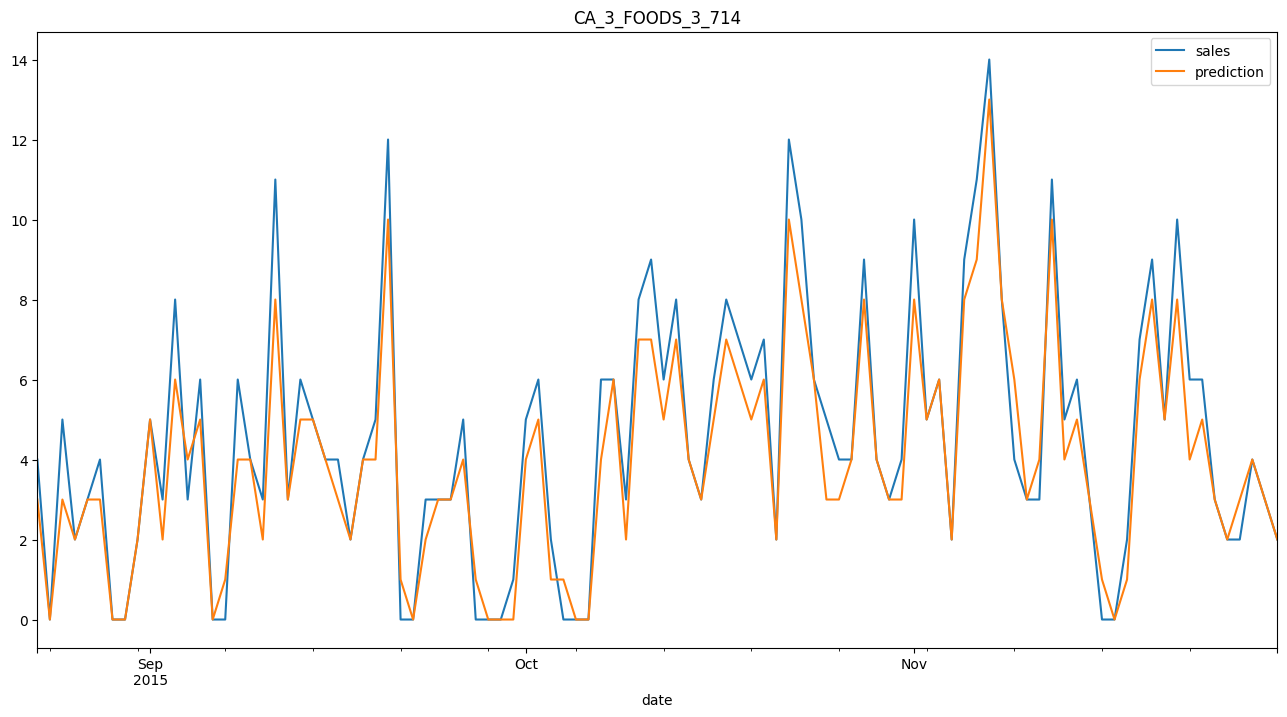

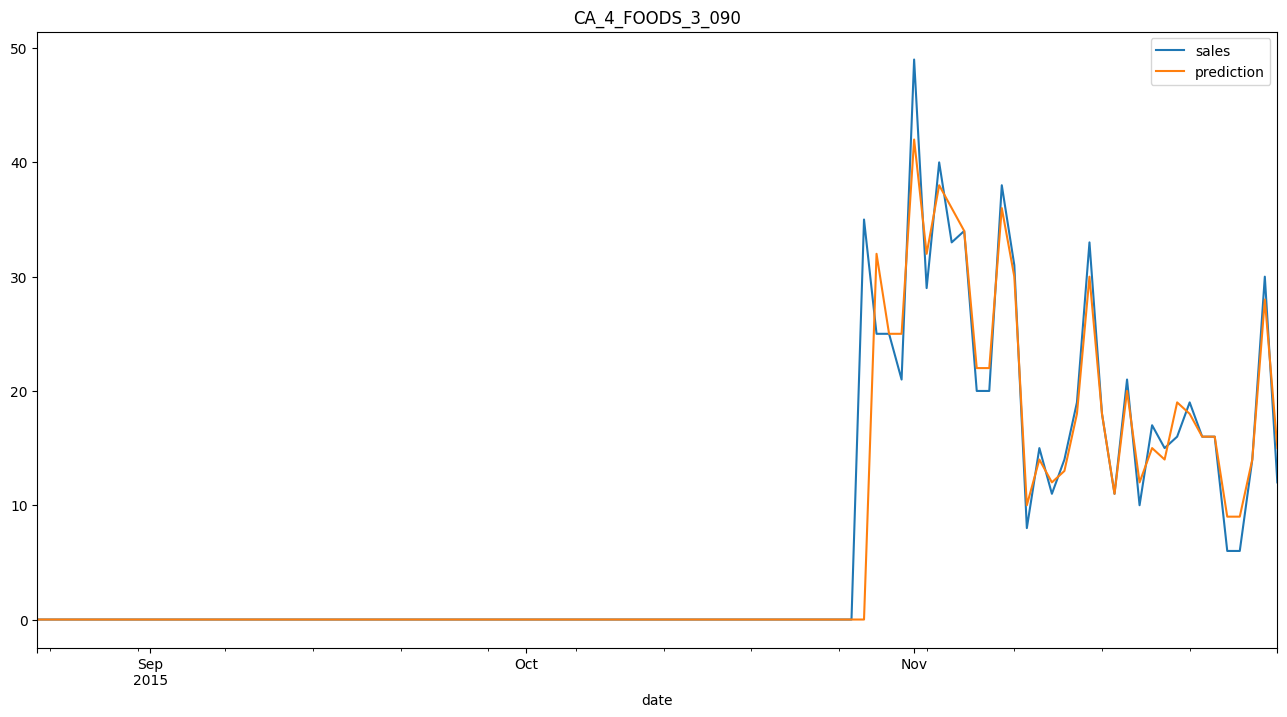

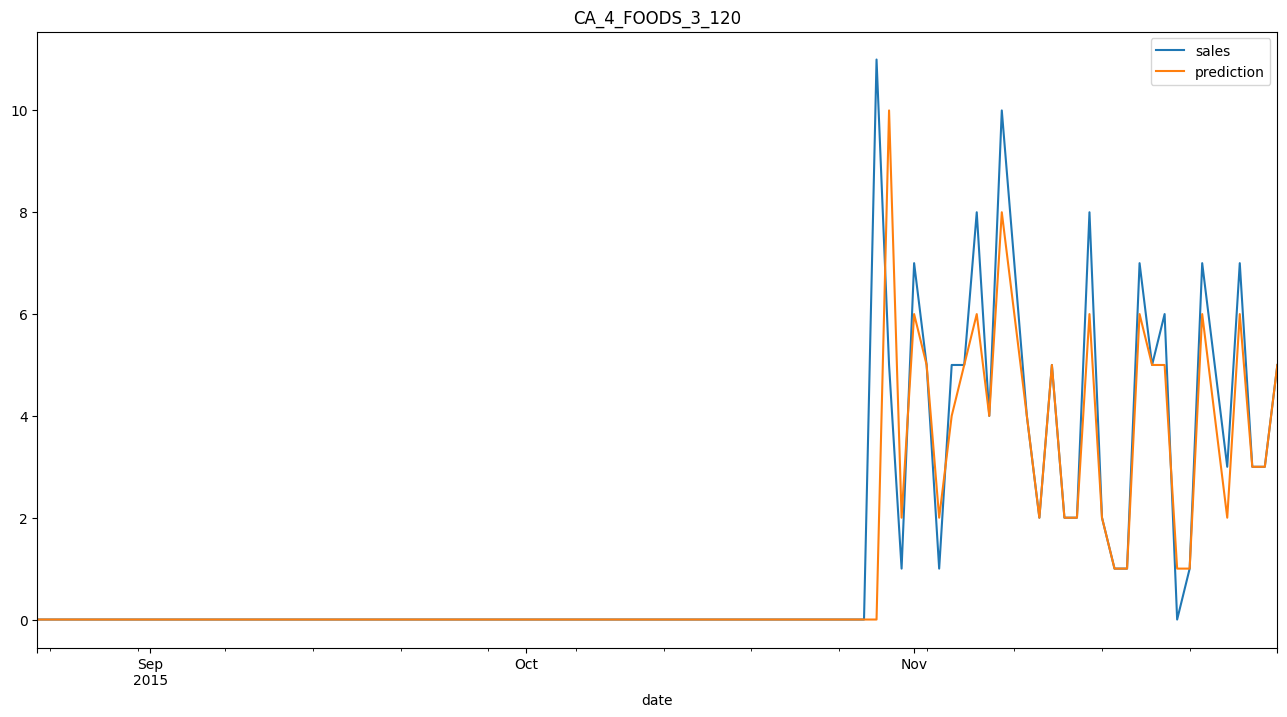

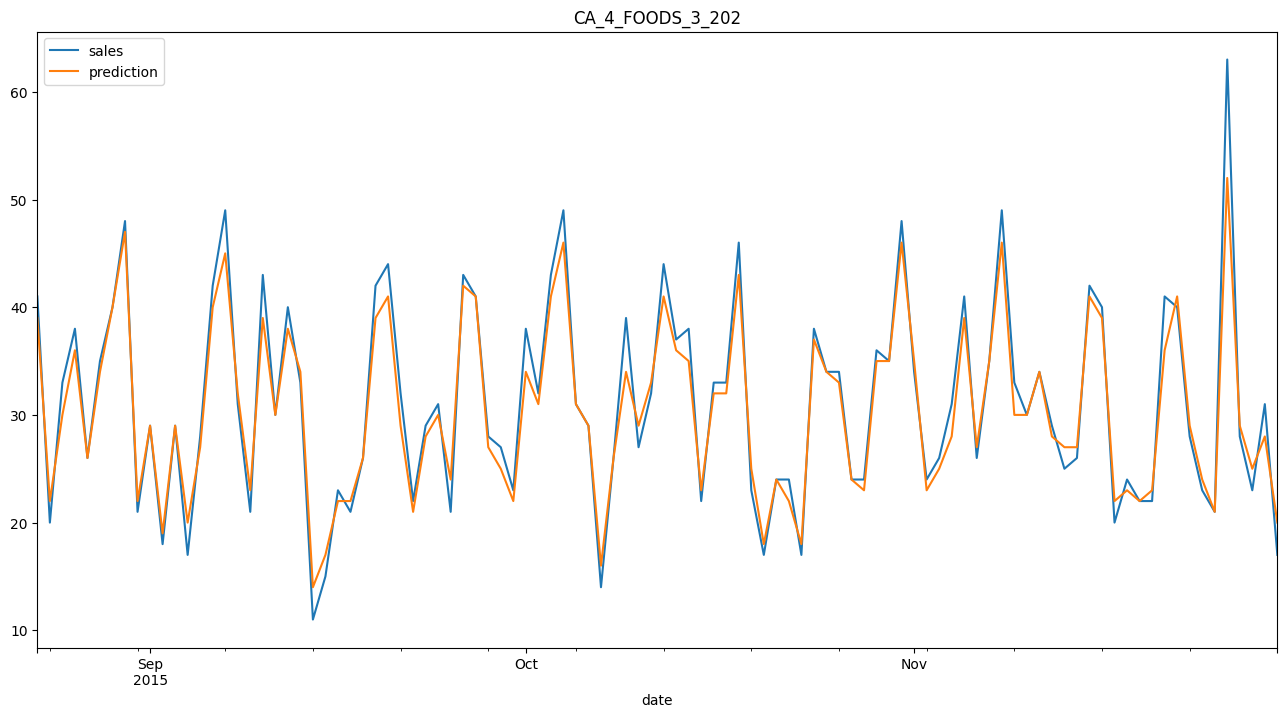

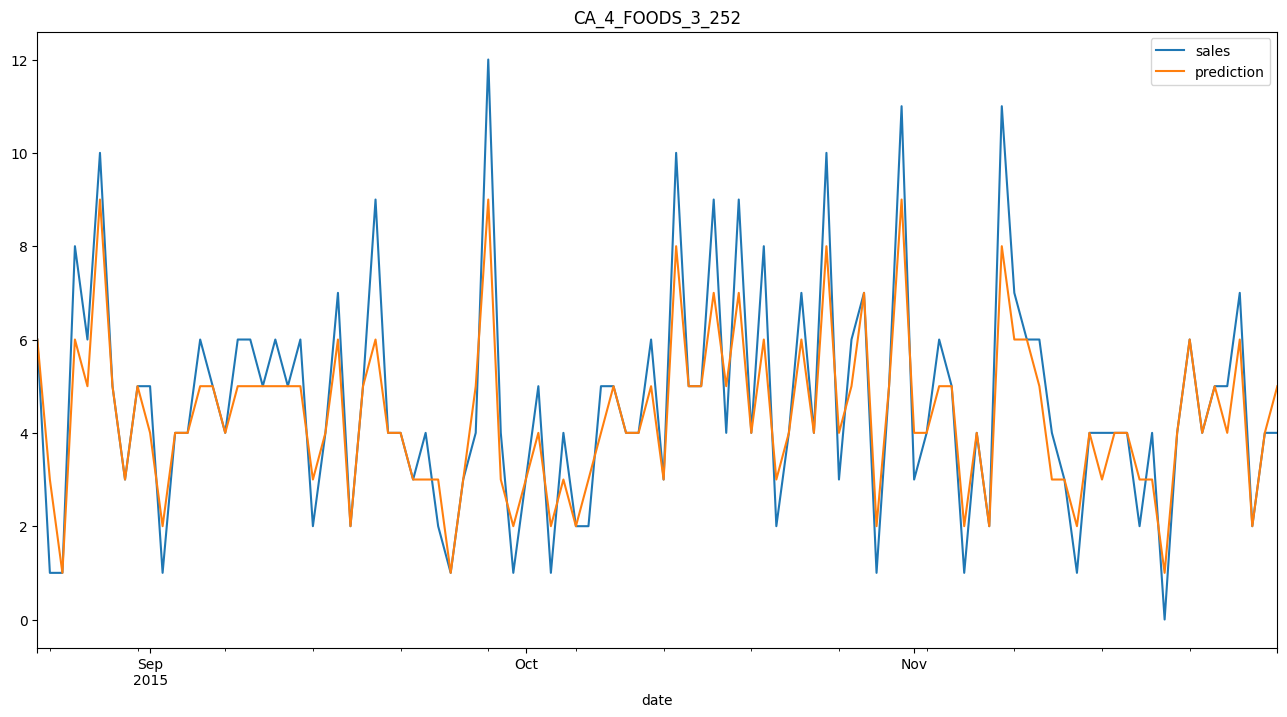

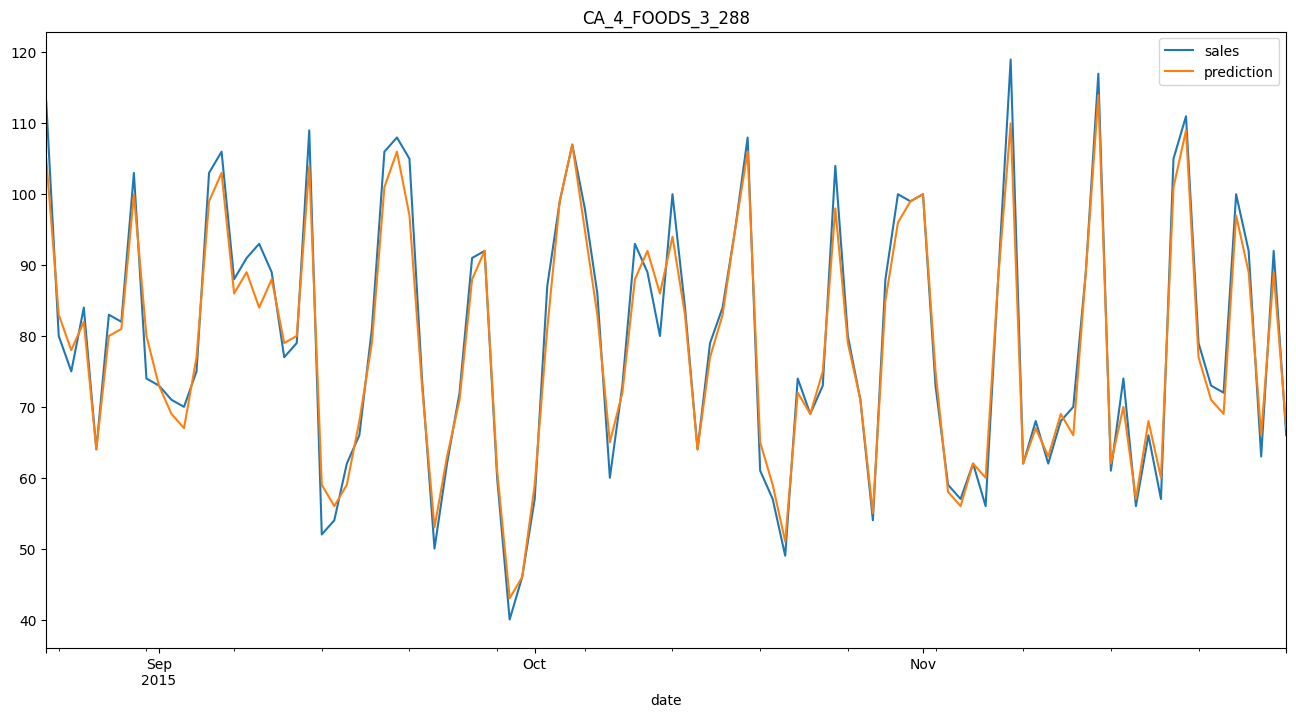

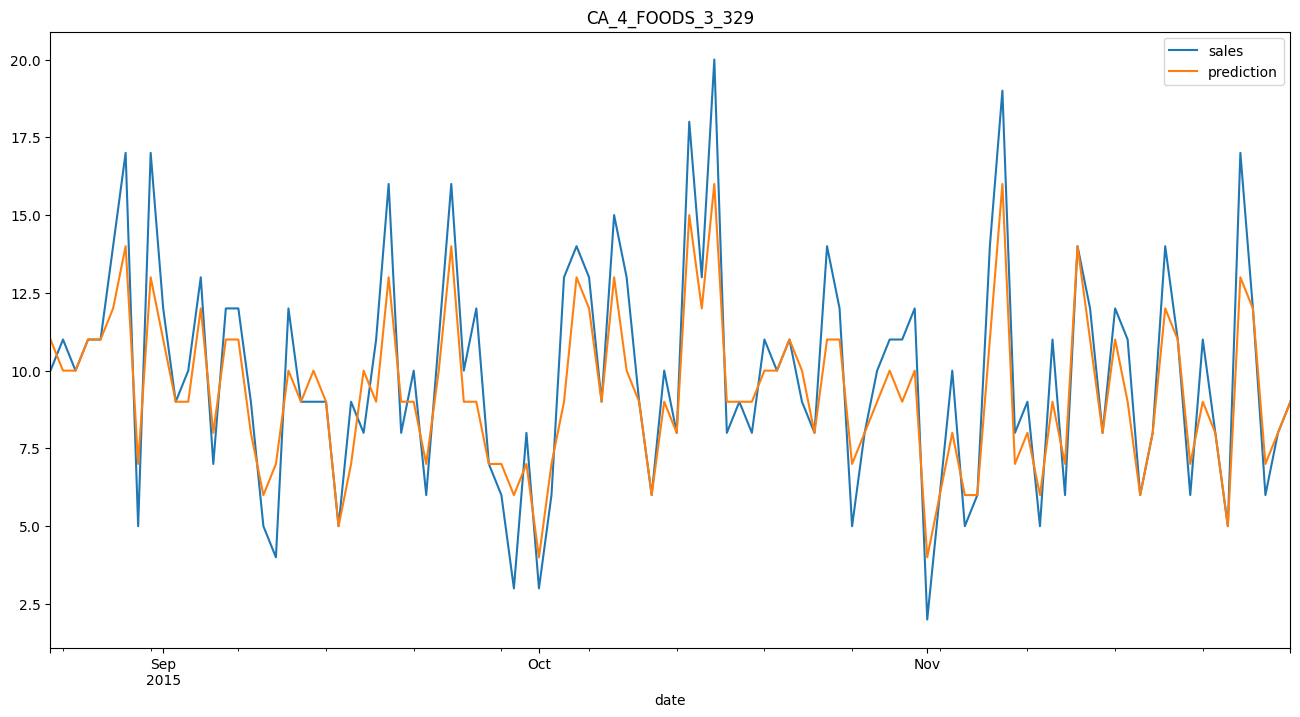

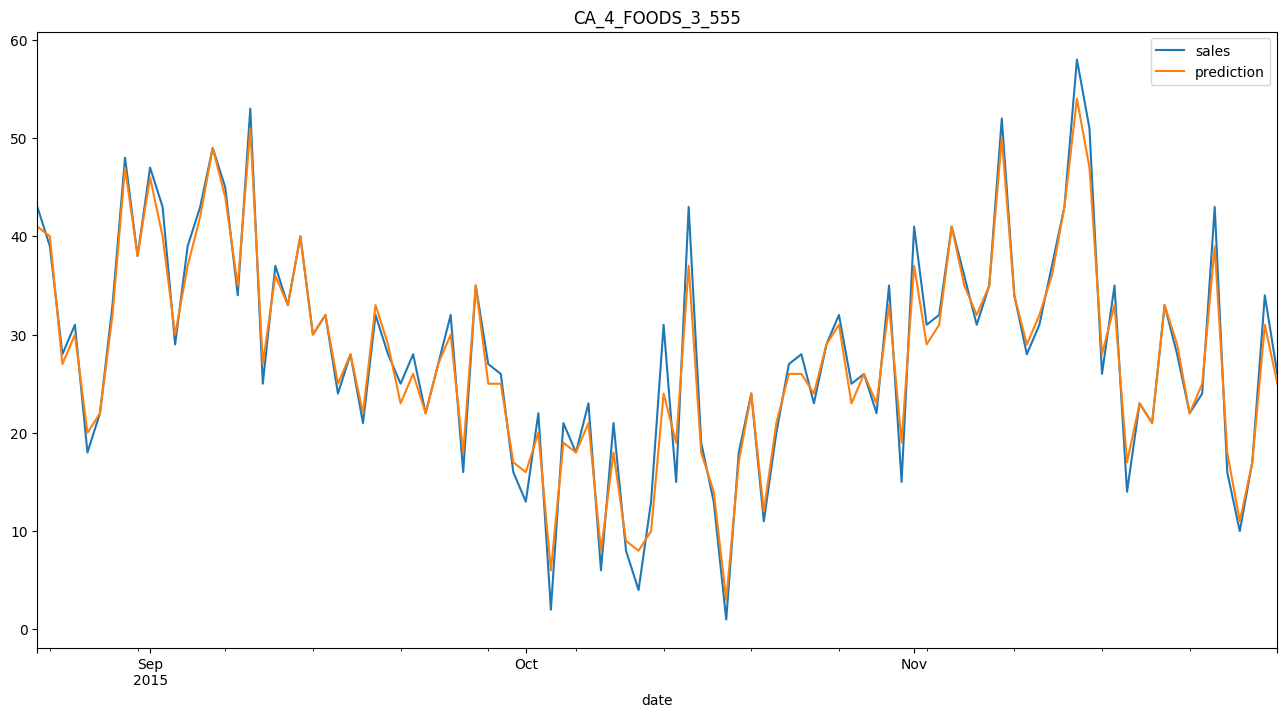

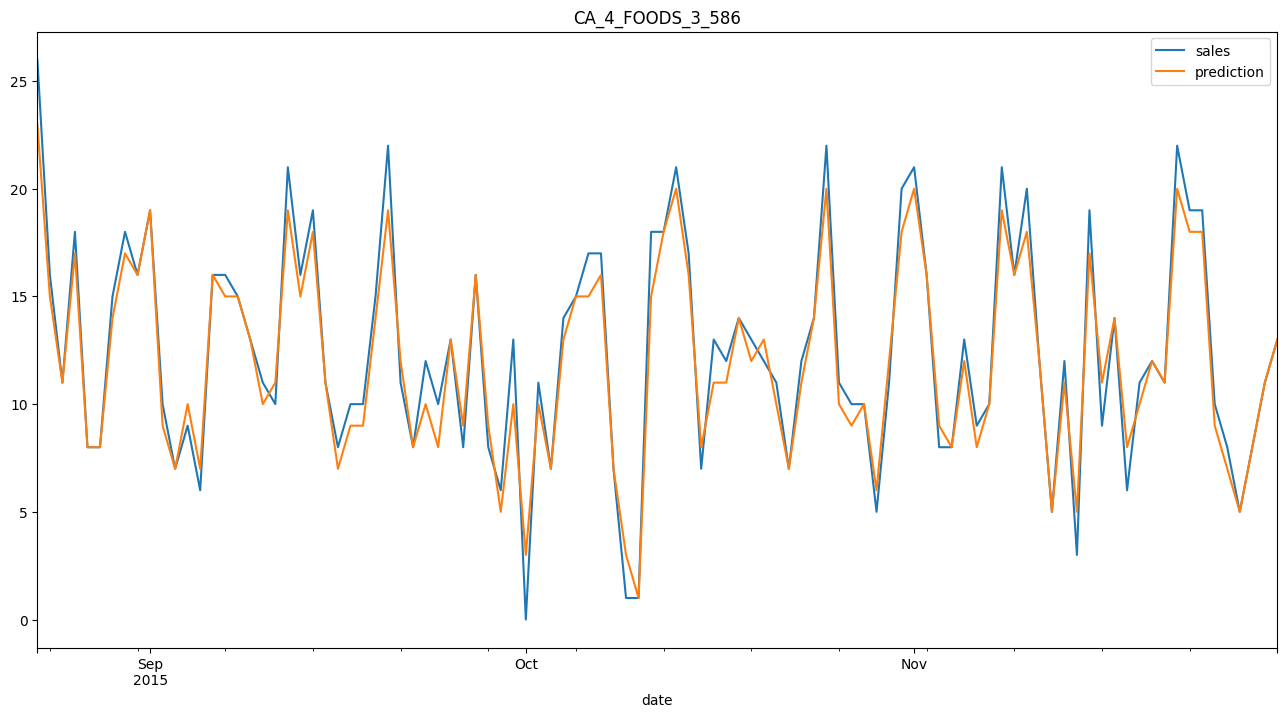

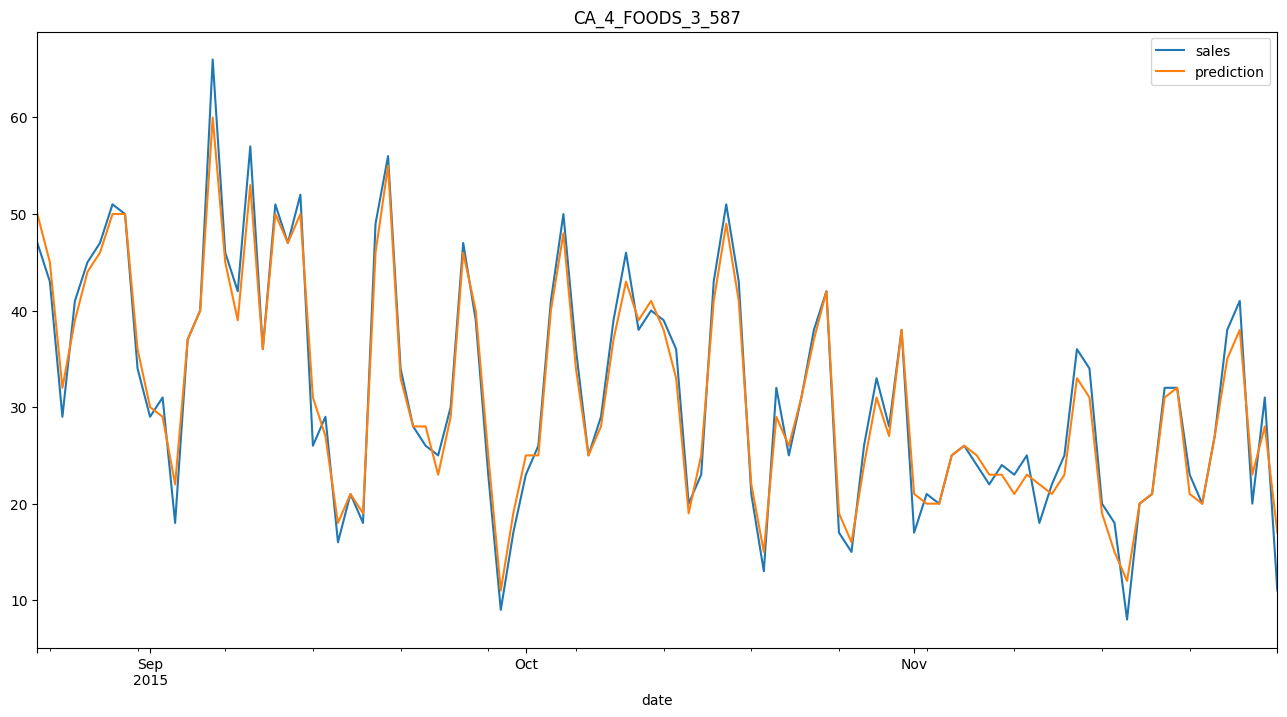

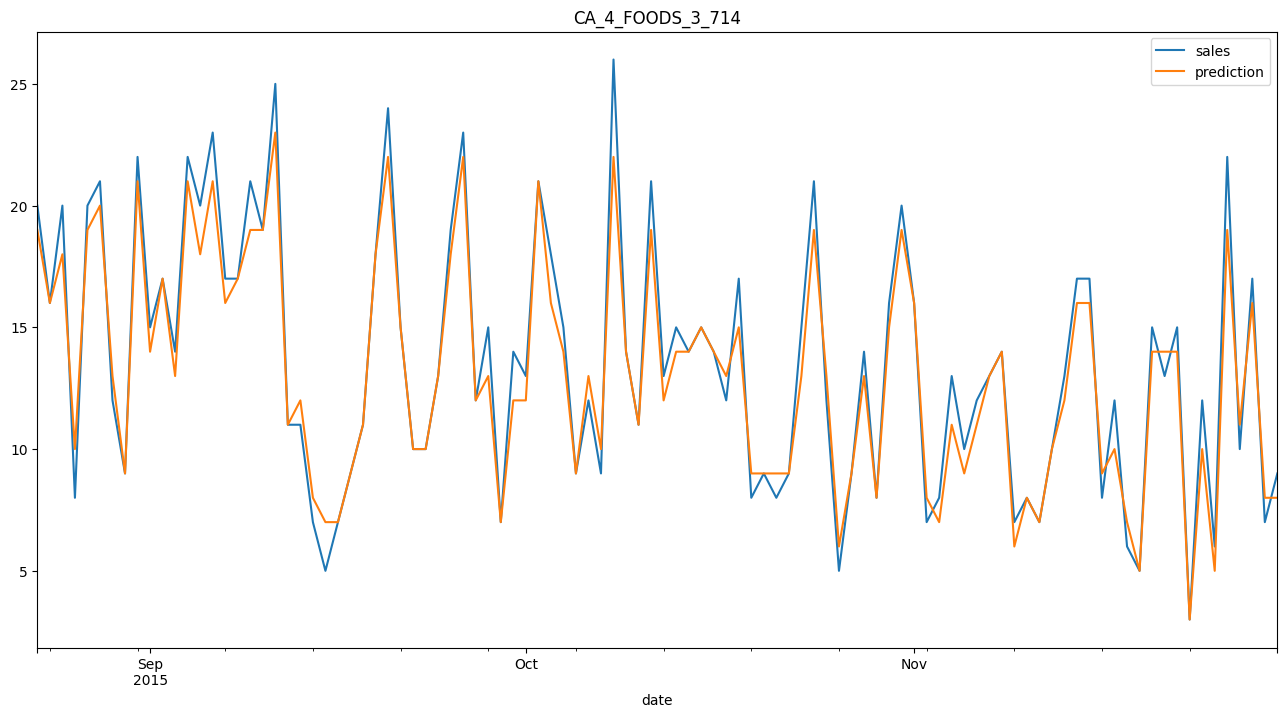

In [28]:
df = pd.concat([x,y], axis=1)

# For all the product_store and model, create the predictions for each product_store 
# and plot the actual sales against the forecasted values by each model
for i in range(0, len(list_models)):

    # Prepare data
    product = list_models[i][0]
    model = list_models[i][1]
    variables = model[0].feature_names_in_
    target = "sales"

    x_prod = df.loc[df["product_store"] == product].drop(columns=target).copy()
    y_prod = df.loc[df["product_store"] == product, target].copy()

    date = x_prod["date"]

    # Create plots for each product_store and model
    predictions = pd.DataFrame(data={"date":date, 
                                     "product": product,
                                     "sales":y_prod,
                                     "prediction": model.predict(x_prod[variables])})
    
    predictions["prediction"] = predictions["prediction"].astype("int")
    predictions.set_index("date", inplace=True)

    predictions.tail(100).plot(figsize=(16,8), title=product);